In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import requests
import io
import time

In [2]:
#lat and lon

# Create a dictionary with key-value pairs
upper_basin_reservoirs = {
    "100010": ['Granby', 'Arizona', '40.15966','-105.86436' ],
    "919": ['Lake Powell', 'Colorado', '36.93649', '-111.48396'],
    "100002": ['Dillon', 'Colorado', '39.61614', '-106.05487'],
    "100089": ['Green Mountain', 'Green Mountain','39.87964', '-106.30589'],
    "2002": ['Ruedi', 'Colorado', '39.36564', '-106.8042'],
    "100053": ['Williams Fork', 'Colorado','40.01882', '-106.21381'],
    "100049": ['Shadow Mountain', 'Colorado', '40.22698', '-105.84385'],
    "917": ['Flaming Gorge', 'Colorado', '40.91474', '-109.42185'],
    "962": ['Strawberry', 'Utah', '40.13564', '-111.02659'],
    "916": ['Fontenelle', 'Wyoming', '42.02617', '-110.06816'],
    "928": ['Starvation', 'Utah', '42.02617', '-110.06816'],
    "931": ['Scofield', 'Utah', '39.77656', '-111.05074'],
    "932": ['Joes Valley', 'Utah', '39.2901', '-111.27888'],
    "930": ['Moon Lake', 'Utah', '40.57445', '-110.50665'],
    "936": ['Big Sandy', 'Wyoming', '42.24993', '-109.42803'],
    "963": ['Upper Stillwater', 'Utah' ,'40.56565', '-110.70044'],
    "944": ['Meeks Cabin', 'Utah', '41.01664', '-110.58344'],
    "949": ['Stateline', 'Utah', '40.98291', '-110.39038'],
    "913": ['Blue Mesa', 'Colorado', '38.45305', '-107.33677'],
    "914": ['Morrow Point', 'Colorado', '38.45191', '-107.53791'],
    "912": ['Taylor Park Reservoir', 'Colorado', '38.81844', '-106.60592'],
    "948": ['Ridgway', 'Colorado', '38.23636', '-107.75914'],
    "915": ['Crystal', 'Colorado', '38.51046', '-107.62374'],
    "958": ['McPhee', 'Colorado', '37.57588', '-108.57307'],
    "920": ['Navajo', "New Mexico", '36.80063', '-107.61203'],
    "933": ['Vallecito', 'Colorado', '37.37834', '-107.57486'],
    "934": ['Lemon', 'Colorado', '37.39538', '-107.57486'],
    
}

lower_basin_reservoirs = {
    "921": ['Lake Mead', 'AZ, NV', '36.0163', '-114.7374'],
    "922": ['Lake Mohave', 'AZ, NV', '35.1979', '-114.5694'],
    "923": ['Lake Havasu', 'AZ, CA', '34.2964', '-114.1385']
}



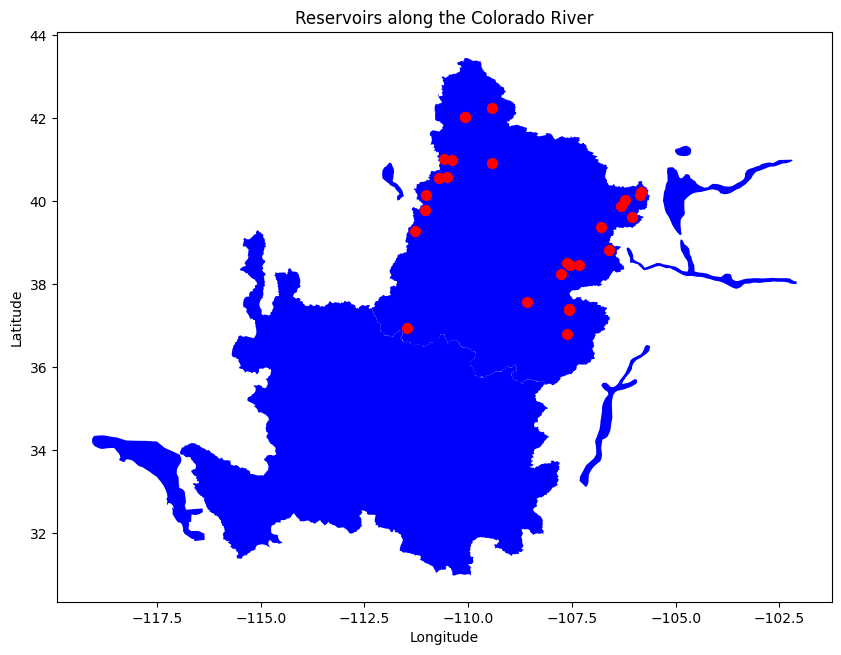

In [3]:
import geopandas as gpd
import matplotlib.pyplot as plt

crb = gpd.read_file("~/remoteData/shapefiles/Colorado_River_Basin_Hydrological_Boundaries_with_Areas_served_by_Colorado_River.shp")


upper_basin_reservoirs_coordinates = [(float(lon), float(lat)) for _, (_, _, lat, lon) in upper_basin_reservoirs.items()]
upper_basin_reservoirs_df = gpd.GeoDataFrame(geometry=gpd.points_from_xy([lon for lon, lat in upper_basin_reservoirs_coordinates], [lat for lon, lat in upper_basin_reservoirs_coordinates]))
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the Colorado River shapefile as the background
crb.plot(ax=ax, color='blue')

# Plot the reservoirs on top of the shapefile
upper_basin_reservoirs_df.plot(ax=ax, color='red', marker='o', markersize=50)

# Add title and labels if needed
plt.title('Reservoirs along the Colorado River')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Show the plot
plt.show()

In [4]:
import requests
import pandas as pd
from io import StringIO

# Function to download data from URL and handle retries
def download_data(url):
    max_attempts = 3
    for attempt in range(1, max_attempts + 1):
        try:
            # Retrieve data from the URL
            response = requests.get(url)
            response.raise_for_status()  # Raise exception for non-200 status codes

            # Read the downloaded content into a DataFrame
            df = pd.read_csv(io.StringIO(response.text))

            # Convert the unit from acre-feet to cubic kilometers for the current reservoir
            df['storage'] *= 0.000001233

            # Extract relevant columns (datetime and storage)
            df = df[['datetime', 'storage']]

            # Add additional columns for reservoir name, latitude, and longitude
            df['lat'] = info[2]
            df['lon'] = info[3]
            df['reservoir_name'] = info[0]
           

            return df  # Return the dataframe on successful download
        except (requests.RequestException, pd.errors.ParserError) as e:
            if attempt < max_attempts:
                print(f"Download attempt {attempt} failed. Retrying...")
                time.sleep(2)  # Wait for 2 seconds before retrying
            else:
                print("Failed to download data. Max attempts reached.")
                return None

template_url = "https://www.usbr.gov/uc/water/hydrodata/reservoir_data/{}/csv/17.csv"

# Initialize an empty list to store dataframes for each reservoir
dfs = []

# Iterate over the upper basin reservoirs
for upper_reservoir_number, info in upper_basin_reservoirs.items():
    # Generate the URL for the current reservoir
    url = template_url.format(upper_reservoir_number)
    print(f"Downloading data for {info[0]}...")
    
    # Download data for the current reservoir and add it to the list
    df = download_data(url)
    if df is not None:
        dfs.append(df)

# Combine all dataframes into a single dataframe for the upper basin
upper_basin_df = pd.concat(dfs)

# Reset the list of dataframes for the lower basin
dfs = []

# Iterate over the lower basin reservoirs
for lower_reservoir_number, info in lower_basin_reservoirs.items():
    # Generate the URL for the current reservoir
    url = template_url.format(lower_reservoir_number)
    print(f"Downloading data for {info[0]}...")

    # Download data for the current reservoir and add it to the list
    df = download_data(url)
    if df is not None:
        dfs.append(df)

# Combine all dataframes into a single dataframe for the lower basin
lower_basin_df = pd.concat(dfs)

# Convert 'datetime' column to datetime type for both dataframes
upper_basin_df['datetime'] = pd.to_datetime(upper_basin_df['datetime'])
upper_basin_df['basin'] = 'upper basin'
lower_basin_df['datetime'] = pd.to_datetime(lower_basin_df['datetime'])
lower_basin_df['basin'] = 'lower basin'
storage_df = pd.concat([upper_basin_df, lower_basin_df], axis=0)
# Display the combined dataframes
print(storage_df)

        datetime   storage       lat         lon reservoir_name        basin
0     1951-09-01  0.365136  40.15966  -105.86436         Granby  upper basin
1     1951-09-02  0.365467  40.15966  -105.86436         Granby  upper basin
2     1951-09-03  0.365667  40.15966  -105.86436         Granby  upper basin
3     1951-09-04  0.365867  40.15966  -105.86436         Granby  upper basin
4     1951-09-05  0.366065  40.15966  -105.86436         Granby  upper basin
...          ...       ...       ...         ...            ...          ...
30973 2023-07-20  0.713043   34.2964   -114.1385    Lake Havasu  lower basin
30974 2023-07-21  0.711575   34.2964   -114.1385    Lake Havasu  lower basin
30975 2023-07-22  0.709873   34.2964   -114.1385    Lake Havasu  lower basin
30976 2023-07-23  0.710852   34.2964   -114.1385    Lake Havasu  lower basin
30977 2023-07-24  0.713928   34.2964   -114.1385    Lake Havasu  lower basin

[595405 rows x 6 columns]


In [5]:
#Upper Basin: Wolford Mountain

import requests
import pandas as pd
from io import StringIO

# Retrieve the content from the URL
url = "https://waterdata.usgs.gov/co/nwis/dv?cb_00054=on&format=rdb&site_no=09041395&legacy=&referred_module=sw&period=&begin_date=1998-10-01&end_date=2023-07-18"
response = requests.get(url)
file_content = response.text

# Find the start position of the table
start_pos = file_content.find("agency_cd\tsite_no\tdatetime\t")

# Extract the table content
table_content = file_content[start_pos:]

# Convert the table content into a DataFrame
Wolford_Mountain = pd.read_csv(StringIO(table_content), delimiter="\t")

# Extract only the desired columns: 'datetime' and '18490_00054_32400' (Storage)
Wolford_Mountain = Wolford_Mountain[['datetime', '18490_00054_32400']]

# Rename the columns
Wolford_Mountain.columns = ['datetime', 'storage']

# Drop the first row
Wolford_Mountain = Wolford_Mountain.drop(0)

# Convert 'storage' column to numeric (ignore non-numeric values, set them to NaN)
Wolford_Mountain['storage'] = pd.to_numeric(Wolford_Mountain['storage'], errors='coerce')

# Drop rows with NaN values in the 'storage' column
Wolford_Mountain = Wolford_Mountain.dropna(subset=['storage'])

# Add new columns for 'lat' and 'lon' with the provided values
Wolford_Mountain['lat'] = '40.11294'
Wolford_Mountain['lon'] = '-106.414'

# Add a new column for 'reservoir' and set its value
Wolford_Mountain['reservoir_name'] = 'Wolford Mountain'

# Multiply 'storage' column by the conversion factor
Wolford_Mountain['storage'] *= 0.000001233

Wolford_Mountain['datetime'] = pd.to_datetime(Wolford_Mountain['datetime'])

# Display the DataFrame with 'datetime', 'Storage', 'lat', 'lon', and 'reservoir' columns
print(Wolford_Mountain)


       datetime   storage       lat       lon    reservoir_name
1    1998-10-01  0.063253  40.11294  -106.414  Wolford Mountain
2    1998-10-02  0.063006  40.11294  -106.414  Wolford Mountain
3    1998-10-03  0.062883  40.11294  -106.414  Wolford Mountain
4    1998-10-04  0.062760  40.11294  -106.414  Wolford Mountain
5    1998-10-05  0.062636  40.11294  -106.414  Wolford Mountain
...         ...       ...       ...       ...               ...
9053 2023-07-14  0.081279  40.11294  -106.414  Wolford Mountain
9054 2023-07-15  0.081242  40.11294  -106.414  Wolford Mountain
9055 2023-07-16  0.081242  40.11294  -106.414  Wolford Mountain
9056 2023-07-17  0.081255  40.11294  -106.414  Wolford Mountain
9057 2023-07-18  0.081218  40.11294  -106.414  Wolford Mountain

[6835 rows x 5 columns]


In [6]:
storage_df

,datetime,storage,lat,lon,reservoir_name,basin
0,1951-09-01,0.365136,40.15966,-105.86436,Granby,upper basin
1,1951-09-02,0.365467,40.15966,-105.86436,Granby,upper basin
2,1951-09-03,0.365667,40.15966,-105.86436,Granby,upper basin
3,1951-09-04,0.365867,40.15966,-105.86436,Granby,upper basin
4,1951-09-05,0.366065,40.15966,-105.86436,Granby,upper basin
...,...,...,...,...,...,...
30973,2023-07-20,0.713043,34.2964,-114.1385,Lake Havasu,lower basin
30974,2023-07-21,0.711575,34.2964,-114.1385,Lake Havasu,lower basin
30975,2023-07-22,0.709873,34.2964,-114.1385,Lake Havasu,lower basin
30976,2023-07-23,0.710852,34.2964,-114.1385,Lake Havasu,lower basin


In [7]:
Wolford_Mountain

,datetime,storage,lat,lon,reservoir_name
1,1998-10-01,0.063253,40.11294,-106.414,Wolford Mountain
2,1998-10-02,0.063006,40.11294,-106.414,Wolford Mountain
3,1998-10-03,0.062883,40.11294,-106.414,Wolford Mountain
4,1998-10-04,0.062760,40.11294,-106.414,Wolford Mountain
5,1998-10-05,0.062636,40.11294,-106.414,Wolford Mountain
...,...,...,...,...,...
9053,2023-07-14,0.081279,40.11294,-106.414,Wolford Mountain
9054,2023-07-15,0.081242,40.11294,-106.414,Wolford Mountain
9055,2023-07-16,0.081242,40.11294,-106.414,Wolford Mountain
9056,2023-07-17,0.081255,40.11294,-106.414,Wolford Mountain


In [8]:
#Lower Basin: 


# Retrieve the content from the URL
url = "https://waterdata.usgs.gov/nwis/dv?cb_00054=on&format=rdb&site_no=09509501&legacy=&referred_module=sw&period=&begin_date=1900-07-16&end_date=2023-07-16"
response = requests.get(url)
file_content = response.text

# Find the start position of the table
start_pos = file_content.find("agency_cd\tsite_no\tdatetime\t")

# Extract the table content
table_content = file_content[start_pos:]

# Convert the table content into a DataFrame
Horseshoe = pd.read_csv(StringIO(table_content), delimiter="\t")



# Extract only the desired columns: 'datetime' and '18490_00054_32400' (Storage)
Horseshoe = Horseshoe[['datetime', '5722_00054_32400']]

# Rename the columns
Horseshoe.columns = ['datetime', 'storage']

# Drop the first row
Horseshoe = Horseshoe.drop(0)

# Convert 'storage' column to numeric (ignore non-numeric values, set them to NaN)
Horseshoe['storage'] = pd.to_numeric(Horseshoe['storage'], errors='coerce')

# Drop rows with NaN values in the 'storage' column
Horseshoe = Horseshoe.dropna(subset=['storage'])

# Add new columns for 'lat' and 'lon' with the provided values
Horseshoe['lat'] = '33.98476097'
Horseshoe['lon'] = '-111.7104223'

# Add a new column for 'reservoir' and set its value
Horseshoe['reservoir_name'] = 'Horseshoe'

# Multiply 'storage' column by the conversion factor
Horseshoe['storage'] *= 0.000001233


Horseshoe

,datetime,storage,lat,lon,reservoir_name
1,1974-10-01,0.003009,33.98476097,-111.7104223,Horseshoe
2,1974-10-02,0.002799,33.98476097,-111.7104223,Horseshoe
3,1974-10-03,0.002663,33.98476097,-111.7104223,Horseshoe
4,1974-10-04,0.002663,33.98476097,-111.7104223,Horseshoe
5,1974-10-05,0.002429,33.98476097,-111.7104223,Horseshoe
...,...,...,...,...,...
17817,2023-07-12,0.120501,33.98476097,-111.7104223,Horseshoe
17818,2023-07-13,0.120353,33.98476097,-111.7104223,Horseshoe
17819,2023-07-14,0.120131,33.98476097,-111.7104223,Horseshoe
17820,2023-07-15,0.119909,33.98476097,-111.7104223,Horseshoe


In [9]:
#Lower Basin: 


# Retrieve the content from the URL
url = "https://waterdata.usgs.gov/nwis/dv?cb_00054=on&format=rdb&site_no=09469000&legacy=&referred_module=sw&period=&begin_date=1982-10-01&end_date=2023-07-16"
response = requests.get(url)
file_content = response.text

# Find the start position of the table
start_pos = file_content.find("agency_cd\tsite_no\tdatetime\t")

# Extract the table content
table_content = file_content[start_pos:]

# Convert the table content into a DataFrame
San_Carlos = pd.read_csv(StringIO(table_content), delimiter="\t")



# Extract only the desired columns: 'datetime' and '18490_00054_32400' (Storage)
San_Carlos = San_Carlos[['datetime', '5495_00054_00003']]

# Rename the columns
San_Carlos.columns = ['datetime', 'storage']

# Drop the first row
San_Carlos = San_Carlos.drop(0)

# Convert 'storage' column to numeric (ignore non-numeric values, set them to NaN)
San_Carlos['storage'] = pd.to_numeric(San_Carlos['storage'], errors='coerce')

# Drop rows with NaN values in the 'storage' column
San_Carlos = San_Carlos.dropna(subset=['storage'])

# Add new columns for 'lat' and 'lon' with the provided values
San_Carlos['lat'] = '33.17561648'
San_Carlos['lon'] = '-110.5278775'

# Add a new column for 'reservoir' and set its value
San_Carlos['reservoir_name'] = 'San Carlos'

# Multiply 'storage' column by the conversion factor
San_Carlos['storage'] *= 0.000001233


San_Carlos

,datetime,storage,lat,lon,reservoir_name
1827,1987-10-01,0.611568,33.17561648,-110.5278775,San Carlos
1828,1987-10-02,0.611568,33.17561648,-110.5278775,San Carlos
1829,1987-10-03,0.611568,33.17561648,-110.5278775,San Carlos
1830,1987-10-04,0.611568,33.17561648,-110.5278775,San Carlos
1831,1987-10-05,0.611568,33.17561648,-110.5278775,San Carlos
...,...,...,...,...,...
14895,2023-07-12,0.554234,33.17561648,-110.5278775,San Carlos
14896,2023-07-13,0.552507,33.17561648,-110.5278775,San Carlos
14897,2023-07-14,0.550411,33.17561648,-110.5278775,San Carlos
14898,2023-07-15,0.548562,33.17561648,-110.5278775,San Carlos


In [10]:
San_Carlos

,datetime,storage,lat,lon,reservoir_name
1827,1987-10-01,0.611568,33.17561648,-110.5278775,San Carlos
1828,1987-10-02,0.611568,33.17561648,-110.5278775,San Carlos
1829,1987-10-03,0.611568,33.17561648,-110.5278775,San Carlos
1830,1987-10-04,0.611568,33.17561648,-110.5278775,San Carlos
1831,1987-10-05,0.611568,33.17561648,-110.5278775,San Carlos
...,...,...,...,...,...
14895,2023-07-12,0.554234,33.17561648,-110.5278775,San Carlos
14896,2023-07-13,0.552507,33.17561648,-110.5278775,San Carlos
14897,2023-07-14,0.550411,33.17561648,-110.5278775,San Carlos
14898,2023-07-15,0.548562,33.17561648,-110.5278775,San Carlos


In [11]:
#Lower Basin: 


# Retrieve the content from the URL
url = "https://waterdata.usgs.gov/nwis/dv?cb_00054=on&format=rdb&site_no=09509502&legacy=&referred_module=sw&period=&begin_date=1964-07-13&end_date=2023-07-19"
response = requests.get(url)
file_content = response.text

# Find the start position of the table
start_pos = file_content.find("agency_cd\tsite_no\tdatetime\t")

# Extract the table content
table_content = file_content[start_pos:]

# Convert the table content into a DataFrame
Bartlett = pd.read_csv(StringIO(table_content), delimiter="\t")



# Extract only the desired columns: 'datetime' and '18490_00054_32400' (Storage)
Bartlett = Bartlett[['datetime', '5723_00054_32400']]

# Rename the columns
Bartlett.columns = ['datetime', 'storage']

# Drop the first row
Bartlett = Bartlett.drop(0)

# Convert 'storage' column to numeric (ignore non-numeric values, set them to NaN)
Bartlett['storage'] = pd.to_numeric(Bartlett['storage'], errors='coerce')

# Drop rows with NaN values in the 'storage' column
Bartlett = Bartlett.dropna(subset=['storage'])

# Add new columns for 'lat' and 'lon' with the provided values
Bartlett['lat'] = '33.81825'
Bartlett['lon'] = ' -111.631856'

# Add a new column for 'reservoir' and set its value
Bartlett['reservoir_name'] = 'Bartlett Dam'

# Multiply 'storage' column by the conversion factor
Bartlett['storage'] *= 0.000001233


Bartlett

,datetime,storage,lat,lon,reservoir_name
1,1974-10-01,0.093523,33.81825,-111.631856,Bartlett Dam
2,1974-10-02,0.093055,33.81825,-111.631856,Bartlett Dam
3,1974-10-03,0.091439,33.81825,-111.631856,Bartlett Dam
4,1974-10-04,0.089590,33.81825,-111.631856,Bartlett Dam
5,1974-10-05,0.087987,33.81825,-111.631856,Bartlett Dam
...,...,...,...,...,...
17287,2022-01-28,0.121401,33.81825,-111.631856,Bartlett Dam
17288,2022-01-29,0.121845,33.81825,-111.631856,Bartlett Dam
17289,2022-01-30,0.122314,33.81825,-111.631856,Bartlett Dam
17290,2022-01-31,0.122573,33.81825,-111.631856,Bartlett Dam


In [12]:
# assuming Bartlett, San_Carlos, Horseshoe, Wolford_Mountain are already defined dataframes
Bartlett['basin'] = 'lower basin'
San_Carlos['basin'] = 'lower basin'
Horseshoe['basin'] = 'lower basin'
Wolford_Mountain['basin'] = 'upper basin'

# concatenate all dataframes
storage_df = pd.concat([storage_df, Bartlett, San_Carlos, Horseshoe, Wolford_Mountain], ignore_index=True)


In [13]:
storage_df['reservoir_name'].value_counts()

reservoir_name
Lake Mead                31469
Lake Havasu              30978
Vallecito                30033
Lake Mohave              26836
Green Mountain           26260
Granby                   26260
Taylor Park Reservoir    23673
Navajo                   22304
Flaming Gorge            22150
Lake Powell              21942
Lemon                    21774
Fontenelle               21092
Blue Mesa                20994
Ruedi                    19838
Starvation               19594
Big Sandy                19432
Joes Valley              19290
Morrow Point             19229
Meeks Cabin              18339
Moon Lake                17799
Scofield                 17799
Strawberry               17618
Horseshoe                17349
Crystal                  16935
Bartlett Dam             16390
Stateline                16098
McPhee                   14371
Dillon                   14293
Ridgway                  13427
Upper Stillwater         12441
Wolford Mountain          6835
Shadow Mountain         

In [16]:
storage_df.to_csv("/home/yhuang21/DSSG2023-Groundwater/Snippets/yuanninghuang/reservoir storage.csv",index=False)